In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import random
import datetime

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout, Concatenate
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)

from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2025-02-10 12:52:22.198639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 12:52:22.198683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 12:52:22.200204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 12:52:22.210321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None # reverses direction of gradient 
    return x, grad

# custom Keras layer
"""
Layer is used to ensure that the feature representation are independent of a sensitive attribute
- feature extract learns normally in the forward pass
- reversing gradients of classifier that tries to predict the sensitive attribute during backpropagation -- stops feature extractor from encoding sensitive information
"""
class GradientReversalLayer(tf.keras.layers.Layer): 
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_ # strength of gradient reversal
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

In [3]:
# -------------------------------
# Adversarial Debiasing Model
# -------------------------------

## has been adjusted for multiclass
def build_adversarial_model(input_dim, num_classes_Y, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Main branch (encoder): from X, several dense layers produce a latent pseudo‑label pseudo_Y (via sigmoid).
      - Adversary branch: pseudo_Y is passed through a Gradient Reversal Layer and then dense layers predict S.
      - Decoder branch: concatenates pseudo_Y and the one-hot sensitive attribute S to predict the observed label Y.

    Losses:
      - For the main branch, binary crossentropy between observed Y and pseudo_Y (and Y_pred).
      - For the adversary branch, categorical crossentropy to predict S.

    Returns a compiled Keras model that takes inputs X and S (one-hot encoded) and outputs:
      [pseudo_Y, S_pred, Y_pred].
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # one-hot encoded S

    # Main branch: Encoder for pseudo-label.
    h = Dense(64, activation='relu')(X_input)
    h = BatchNormalization()(h)
    h = Dense(32, activation='relu')(h)
    h = BatchNormalization()(h)
    pseudo_Y = Dense(num_classes_Y, activation='softmax', name="pseudo_Y")(h) ## changed to softmax because multi-class

    # Adversary branch: from pseudo_Y, with GRL.
    """
    This is to prevent psuedo_Y from containing information about S
    - adversary will try to predict S from pseudo_Y (fair label)...if it can accurately predict S, then Y' still encodes information about S (don't want this) 
    - use the gradient reversal layer to prevent this from happening
    """
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = Dense(32, activation='relu')(grl)
    a = BatchNormalization()(a)
    S_pred = Dense(2, activation='softmax', name="S_pred")(a)

    # Decoder branch: combine pseudo_Y and S to predict observed Y.
    concat = Concatenate()([pseudo_Y, S_input])
    d = Dense(16, activation='relu')(concat)
    d = BatchNormalization()(d)
    Y_pred = Dense(num_classes_Y, activation='softmax', name="Y_pred")(d) # changed from 1 to num_classes_Y, changed to softmax cause multi

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "categorical_crossentropy", # changed from binary to categorical
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "categorical_crossentropy"}, # changed from binary to categorical
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"}) # Y_pred is the best estimate of Y accounting for fair dependencies 
    return model

In [34]:
import numpy as np
from sklearn.metrics import accuracy_score

def multi_compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually for multi-class classification.
    
    Args:
      y_true: Ground-truth labels (1D numpy array, categorical).
      y_pred: Predicted labels (1D numpy array, categorical).
      sensitive_features: 1D numpy array (binary sensitive attribute).
    
    Returns:
      Dictionary containing:
        - Demographic parity difference
        - Equalized odds difference
        - Selection rates per group
        - Group-wise accuracy
    """
    
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    sensitive_features = np.array(sensitive_features)

    groups = np.unique(sensitive_features)  # Unique groups in sensitive attribute
    classes = np.unique(y_true)  # Unique class labels

    # -----------------------
    # Demographic Parity Difference
    # -----------------------
    class_rates = {g: np.zeros(len(classes)) for g in groups}

    for g in groups:
        mask = (sensitive_features == g)  # Filter by group
        for i, cl in enumerate(classes):  # Iterate over class labels
            class_rates[g][i] = np.mean(y_pred[mask] == cl)  # Proportion of predictions for class c
    
    dp_diff = np.max([np.abs(class_rates[g1] - class_rates[g2]) 
                      for g1 in groups for g2 in groups if g1 != g2])

    # -----------------------
    # Equalized Odds Difference
    # -----------------------
    """
    Ensuring that different groups in the sensitive feature have similar TPR and FPR rates
    This prevents the model from discriminating based on error types.
    """
    metrics = {g: {c: {"TPR": 0, "FPR": 0} for c in classes} for g in groups}

    y_true = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true # categorical

    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]

        for c in classes:
            tp = np.sum((y_pred_g == c) & (y_true_g == c))
            fn = np.sum((y_pred_g != c) & (y_true_g == c))
            fp = np.sum((y_pred_g == c) & (y_true_g != c))
            tn = np.sum((y_pred_g != c) & (y_true_g != c))

            # Avoid division by zero
            metrics[g][c]["TPR"] = tp / (tp + fn) if (tp + fn) > 0 else 0
            metrics[g][c]["FPR"] = fp / (fp + tn) if (fp + tn) > 0 else 0

    # Compute max difference across groups
    eo_diff_vals = []
    for g1 in groups:
        for g2 in groups:
            if g1 != g2:  # Compare across different groups
                for c in classes:
                    tpr_diff = np.abs(metrics[g1][c]["TPR"] - metrics[g2][c]["TPR"])
                    fpr_diff = np.abs(metrics[g1][c]["FPR"] - metrics[g2][c]["FPR"])
                    eo_diff_vals.append(tpr_diff + fpr_diff)

    eo_diff = np.max(eo_diff_vals) if eo_diff_vals else 0  # Avoid empty list issue

    # -----------------------
    # Selection Rate Per Group
    # -----------------------
    selection_rate = {g: class_rates[g].tolist() for g in groups}

    # -----------------------
    # Group-Wise Accuracy
    # -----------------------
    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": selection_rate,
        "group_accuracy": group_acc
    }




# # -------------------------------
# # Manual Fairness Metrics
# # -------------------------------

# # changed for multi
# def multi_compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
#     """
#     Compute fairness metrics manually.
#     y_true: binary ground-truth labels (1-D numpy array).
#     y_pred: continuous scores (will be thresholded at 0.5).
#     sensitive_features: 1-D numpy array (0 or 1).

#     Returns a dictionary with:
#       - Demographic parity difference (absolute difference in positive rates).
#       - Equalized odds difference (average difference in TPR and FPR).
#       - Selection rates per group.
#       - Group-wise accuracy.
#     """
#     # y_pred_bin = np.argmax(y_pred, axis=1) # converting probability to class prediction
#     y_pred_bin = y_pred
#     groups = np.unique(sensitive_features) # all the different groups in the sensitive feature)
#     classes = np.unique(y_true) # all the different classes in y_true (for multiclass)

#     # Demographic parity 

#     # For each group in the sensitive feature, find the demographic parity and compute the difference (based on the formula in above comment) -- will look at each proportion per class
#     class_rates = {g: np.zeros(len(classes)) for g in groups}

#     for g in groups:
#         mask = (sensitive_features == g) 
#         for cl in classes: 
#             class_rates[g][cl] = np.mean(y_pred_bin[mask] == cl)
#     dp_diff = np.max([np.abs(class_rates[g1] - class_rates[g2]) for g1 in groups for g2 in groups if g1 != g2])


#     # Equalized odds
#     """
#     Ensuring the different groups in the sensitive feature similar TPR and FPR rates -- this is so that the model isn't discriminating in error types
#     """
#     metrics = {g: {c: {"TPR": 0, "FPR": 0} for c in classes} for g in groups}

#     for g in groups:
#         mask = (sensitive_features == g)
#         y_true_g = y_true[mask]
#         y_pred_g = y_pred_bin[mask]

#         for c in unique_classes:
#             tp = np.sum((y_pred_g == c) & (y_true_g == c))
#             fn = np.sum((y_pred_g != c) & (y_true_g == c))
#             fp = np.sum((y_pred_g == c) & (y_true_g != c))
#             tn = np.sum((y_pred_g != c) & (y_true_g != c))

#             metrics[g][c]["TPR"] = tp / (tp + fn) # true positive
#             metrics[g][c]["FPR"] = fp / (fp + tn) # false positive

        
#     eo_diff_vals = []
#     for g1 in groups:
#         for g2 in groups: 
#             if g1 != g2: # trying to compare tpr and fpr across the different groups
#                 for c in classes: 
#                     tpr_diff = np.abs(metrics[g1][c]["TPR"] - metrics[g2][c]["TPR"])
#                     fpr_diff = np.abs(metrics[g1][c]["FPR"] - metrics[g2][c]["FPR"])
#                     eo_diff_vals.append(tpr_diff + fpr_diff)
#     eof_diff = np.max(eo_diff_vals)
                
    
#     # Selection rate per group.
#     """
#     proportion of samples predicted as positive for each group -- a group has a higher selection rate, the model may favor that group unfairly
#     """
#     selection_rate = {g: class_rates[g].tolist() for g in groups}

#     # Group-wise accuracy.
#     """
#     for each group in the sensitive feature, compute the accuracy of the model (to ensure that it's perfoming consistently across groups)
#     """
#     group_acc = {}
#     for g in groups:
#         mask = (sensitive_features == g)
#         group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

#     return {
#         "demographic_parity_difference": dp_diff,
#         "equalized_odds_difference": eo_diff,
#         "selection_rate": sel_rate,
#         "group_accuracy": group_acc
#     }

In [35]:
# -------------------------------
# Plotting Function
# -------------------------------

# changed for multi class
def multi_plot_comparison(metrics_baseline, metrics_fair):
    """
    parameters are dictionaries with the stored values of the evaluation metrics
    """
    models = ['Baseline', 'Fair']
    aucs = [metrics_baseline['auc'], metrics_fair['auc']]
    accs = [metrics_baseline['accuracy'], metrics_fair['accuracy']]
    dp_diff = [metrics_baseline["demographic_parity_difference"], metrics_fair["demographic_parity_difference"]]
    eo_diff = [metrics_baseline["equalized_odds_difference"], metrics_fair["equalized_odds_difference"]]

    # creating a 2x3 gird of bar chars comparing baseline model and fair model across: AUC, accuracy, demographic parity diff, equalized odd difference
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    ## measures how well the model seperates postiive and negative classes, higher AUC = better model performance
    # if fair model has a lower AUC than the baseline, can indicate a fairness-performance tradeoff (meaning less well seperation for more fair results)
    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('AUC')
    axs[0,0].set_ylim([0, 1])

    ## correct pred/total pred
    ## fairness may lower accuracy 
    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    ## orange = baseline, purple = fairness -LOOK INTO TO SEE HOW TO KNOW WHICH GROUP IS CONTRIBUTING TO HIGHER DP
    # lower values of dp indciate better fairness
    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    ## lower value - better fairness
    ## equalized odds is satisfied if tpr and fpr are equal across the different groups in the sensitive feature
    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [40]:
# -------------------------------
# Main Function: Comparison and Visualization
# -------------------------------
def multi_main(data_url, dataset_name, lambda_adv=1.0):
    set_seed(42)

    if dataset_name == "compas": 
        X, Y_obs, S = load_and_preprocess_compas_data_binary(data_url) ##  Y, S is binary
        num_classes_Y = len(np.unique(Y_obs))
    
    elif dataset_name == "drug":
        X, Y_obs, S = load_and_process_drug_consumption_data(data_url) ##  Y is multi class, S is binary
        num_classes_Y = len(np.unique(Y_obs))

    else:
        print ("Invalid dataset_name")
        return 
    
    print(f"Loading and preprocessing {dataset_name} data...")
    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y_obs, S, test_size=0.2, random_state=42
    )

    if dataset_name == "compas":
        print(f"Features shape: {X.shape}")
        print(f"Observed Label Y shape: {Y_obs.shape}   (Recidivism: 1=recid, 0=non-recid)")
        print(f"Sensitive Attribute (Race, binarized) shape: {S.shape}")
        
    elif dataset_name == "drug":
        print(f"Features shape: {X.shape}")
        print(f"Observed Label Y shape: {Y_obs.shape}   (Label from 'drug consumption')")
        print(f"Sensitive Attribute (Education) shape: {S.shape}")

    input_dim = X_train.shape[1]

    # One-hot encode S for adversarial model training.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2) # will need to change this if not longer 2
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2) # will need to change this if no longer 2

    # need to one hot encode Y
    Y_train_obs = tf.keras.utils.to_categorical(Y_train_obs, num_classes=num_classes_Y)
    Y_test_obs = tf.keras.utils.to_categorical(Y_test_obs, num_classes=num_classes_Y)
    
    Y_train_obs_1d = np.argmax(Y_train_obs, axis=1)  # Convert from one-hot to categorical labels
    Y_test_obs_1d = np.argmax(Y_test_obs, axis=1)  # Do the same for test set

    ### 1. Train adversarial debiasing model (X → Y' with adversary)
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, num_classes_Y, lambda_adv=lambda_adv)
    # For training, we use the observed Y as target for both pseudo_Y and Y_pred.
    # Reshape Y_obs to (-1,1) since our outputs are scalars.
    # Y_train_obs_exp = Y_train_obs.reshape(-1, 1)
    # Y_test_obs_exp  = Y_test_obs.reshape(-1, 1)
    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_obs, "S_pred": S_train_oh, "Y_pred": Y_train_obs},
                  epochs=30, batch_size=128, verbose=1)

    # Get pseudo-label predictions.
    pseudo_Y_train, S_pred_train, Y_pred_train = adv_model.predict([X_train, S_train_oh]) ## changed so we're using Y_pred here instead of psuedo_Y
    pseudo_Y_test,  S_pred_test, Y_pred_test = adv_model.predict([X_test, S_test_oh])

    # Threshold pseudo-labels to get binary labels.
    Y_pred_train_bin = np.argmax(Y_pred_train, axis= 1)
    Y_pred_test_bin  = np.argmax(Y_pred_test, axis=1) 

    print("\nPseudo-label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo-positive rate: {np.mean(Y_pred_train_bin[mask]):.4f}") # average probability of a postive prediction per group -- fairness check to see if both groups receive similar treatment

    ### 2. Train baseline logistic regression model on observed Y (X → Y) -- regular logistic regression for baseline for comparison; does not include any fairness constraints
    print("\nTraining baseline logistic regression classifier (X → Y)...")
    baseline_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    baseline_clf.fit(X_train, Y_train_obs_1d)
    
    baseline_preds = baseline_clf.predict_proba(X_test)    
    baseline_auc = roc_auc_score(Y_test_obs, baseline_preds, multi_class="ovr")
    baseline_preds_class = baseline_preds.argmax(axis=1)
    baseline_acc = accuracy_score(Y_test_obs_1d, baseline_preds_class)

    baseline_fairness = multi_compute_fairness_metrics_manual(Y_test_obs, baseline_preds_class, sensitive_features=S_test)

    ### 3. Train fair logistic regression model on pseudo-labels (X → Y') -- using psuedo_Y from the the adv_model, 
    print("\nTraining fair logistic regression classifier (X → Y') using Y_pred labels...")
    fair_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    fair_clf.fit(X_train, Y_pred_train_bin)
    fair_preds = fair_clf.predict_proba(X_test)
    fair_auc = roc_auc_score(Y_test_obs, fair_preds, multi_class='ovr')
    fair_preds_class = fair_preds.argmax(axis=1)
    fair_acc = accuracy_score(Y_test_obs_1d, fair_preds_class)

    fair_fairness = multi_compute_fairness_metrics_manual(Y_test_obs, fair_preds_class, sensitive_features=S_test)

    # Aggregate metrics for plotting.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparison.
    multi_plot_comparison(metrics_baseline, metrics_fair)

### Application on Datasets

#### Drug Consumption Datasets

Loading and preprocessing drug data...
Features shape: (1884, 10)
Observed Label Y shape: (1884,)   (Label from 'drug consumption')
Sensitive Attribute (Education) shape: (1884,)

Training adversarial model (X → Y' with adversary) ...
Epoch 1/30
12/12 [==============================] - 2s 14ms/step - loss: 4.4865 - pseudo_Y_loss: 1.8722 - S_pred_loss: 0.9551 - Y_pred_loss: 1.6592 - pseudo_Y_accuracy: 0.2528 - S_pred_accuracy: 0.5222 - Y_pred_accuracy: 0.3019
Epoch 2/30
12/12 [==============================] - 0s 8ms/step - loss: 4.3971 - pseudo_Y_loss: 1.8406 - S_pred_loss: 0.9332 - Y_pred_loss: 1.6233 - pseudo_Y_accuracy: 0.2681 - S_pred_accuracy: 0.5129 - Y_pred_accuracy: 0.2873
Epoch 3/30
12/12 [==============================] - 0s 8ms/step - loss: 4.3746 - pseudo_Y_loss: 1.8257 - S_pred_loss: 0.9389 - Y_pred_loss: 1.6099 - pseudo_Y_accuracy: 0.2687 - S_pred_accuracy: 0.5109 - Y_pred_accuracy: 0.2960
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 4.3336 - ps

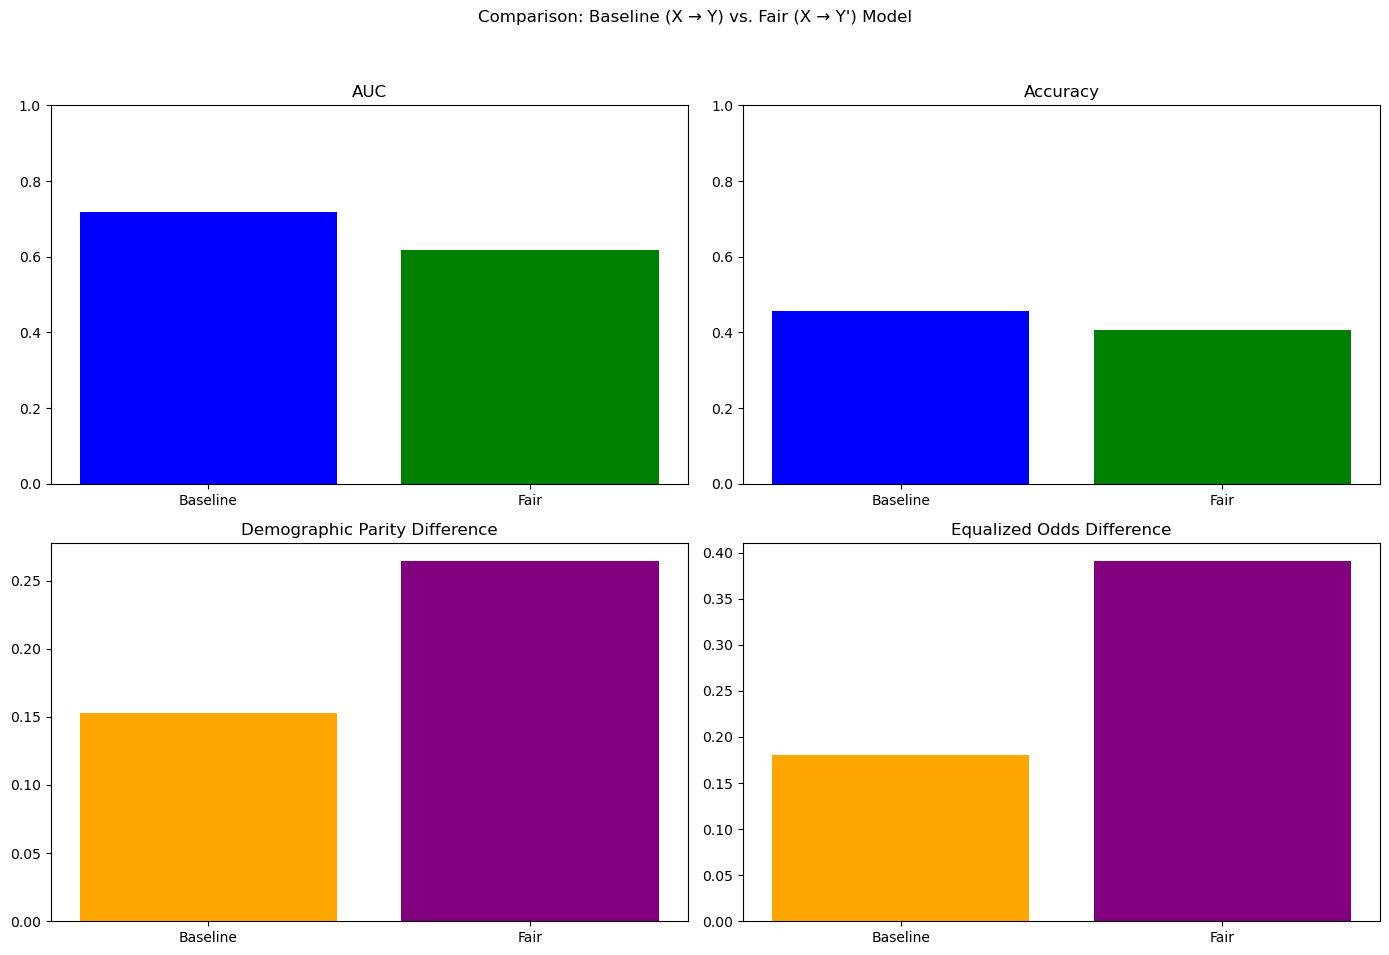

In [41]:
## Good to go
def load_and_process_drug_consumption_data(path):

    # path = os.path.join("data", "drug_consumption.csv")
    path = "../data/drug_consumption.csv"
    
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower().str.strip()
    
    # convert to 4 classes
    df = df[df.columns[1:]]
    df = df.replace(
        {
            "cannabis": {
                "CL0": "never_used",
                "CL1": "not_in_last_year",
                "CL2": "not_in_last_year",
                "CL3": "used_in_last_year",
                "CL4": "used_in_last_year",
                "CL5": "used_in_last_week",
                "CL6": "used_in_last_week",
            }
        }
    )
    
    educated_cat = {
        "University degree",
        "Masters degree",
        "Doctorate degree",
        "Professional certificate/ diploma"
    }
    
    df["education"] = df["education"].apply(lambda x: 1 if x in educated_cat else 0)
    
    # changing to numerical representation
    label_encoder = LabelEncoder()
    # df["age"] = label_encoder.fit_transform(df["age"]) 
    df["country"] = label_encoder.fit_transform(df["country"])
    df["ethnicity"] = label_encoder.fit_transform(df["ethnicity"])
    df["cannabis"] = label_encoder.fit_transform(df["cannabis"])

    
    
    df["gender"] = df["gender"].apply(lambda x: 1 if x == "M" else 0)
    
    X = df[df.columns[1:12]]
    Y = df["cannabis"].to_numpy()
    S = df["education"].to_numpy()
    X = X.drop(columns = ["education"])

    return X, Y, S

multi_main("ANYTHING", "drug", lambda_adv=1.0)

#### Compas Dataset

In [ ]:
# COME BACK AND DO IF WANT TO IMPLEMENT WHERE SENSITIVE FEATURE IS NOT JUST BINARY
def load_and_preprocess_compas_data_multi_cat(data_url):
    """
    Try the algorithm, except instead of binary sensitive feature, it multi classes (so not just Aferican American)? 
    
    Download and preprocess the COMPAS dataset.

    We assume the dataset contains, among others, the following columns:
      - 'age'
      - 'race'
      - 'priors_count'
      - 'juv_fel_count'
      - 'juv_misd_count'
      - 'juv_other_count'
      - 'two_year_recid'

    Features (X): We select a few numerical features.
    Observed Label (Y): Use 'two_year_recid' as a binary label (0/1).
    Protected Attribute (S): Use 'race'. Here we binarize race so that:
         African‑American  → 1
         all other races  → 0.
    """
    data = pd.read_csv(data_url)
    # Drop rows with missing values in the selected columns.
    data = data.dropna(subset=["age", "race", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count", "two_year_recid"])

    # Observed label: two_year_recid (already 0/1)
    Y = data["two_year_recid"].values

    # Sensitive attribute: race. We set S=1 if race is African-American, else 0.
    S = (data["race"] == "African-American").astype(int).values

    # Features: use a subset of numerical features.
    feature_cols = ["age", "priors_count", "juv_fel_count", "juv_misd_count", "juv_other_count"]
    X = data[feature_cols].copy().astype(np.float32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.values)

    return X, Y, S

# URL for the ProPublica COMPAS dataset
compas_data_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
# You can adjust lambda_adv as desired (e.g., lambda_adv=15.5 as in your German data experiment)
main_compas(compas_data_url, lambda_adv=3.1)